توزيع الفئات الحقيقي:
Class
0    284315
1       492
Name: count, dtype: int64

جاري تدريب النموذج... يرجى الانتظار

--- تقرير الأداء النهائي ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.28      0.28      0.28       492

    accuracy                           1.00    284807
   macro avg       0.64      0.64      0.64    284807
weighted avg       1.00      1.00      1.00    284807



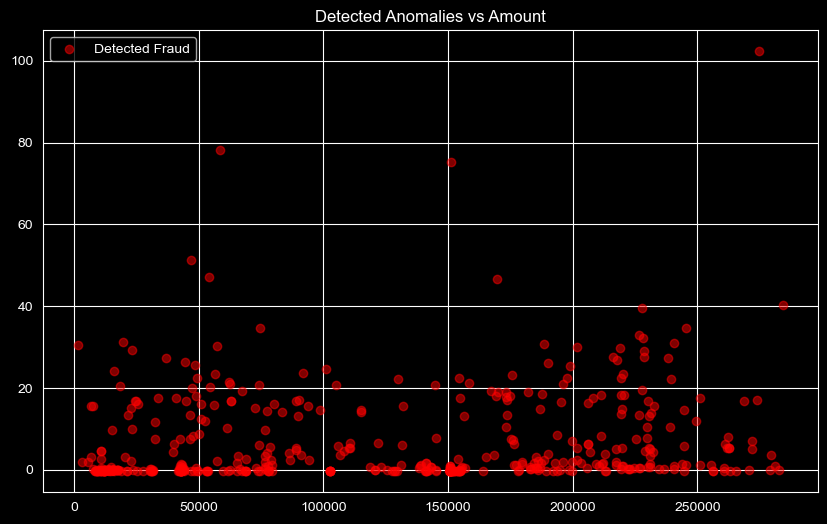

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# --- المرحلة 1: فهم وتحليل البيانات (EDA) ---
# نفترض أن الملف باسم 'creditcard.csv'
df = pd.read_csv('creditcard.csv')

# التأكد من توازن البيانات (Sanity Check)
print("توزيع الفئات الحقيقي:")
print(df['Class'].value_counts())

# --- المرحلة 2: المعالجة المسبقة (Preprocessing) ---
# توحيد مقياس Amount و Time لأن قيمهما ضخمة وتؤثر على المسافات
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df[['Amount']])
df['scaled_time'] = scaler.fit_transform(df[['Time']])

# حذف الأعمدة غير المعالجة والأعمدة المستهدفة للعمل كـ Unsupervised
X = df.drop(['Time', 'Amount', 'Class'], axis=1)

# --- المرحلة 3: اختيار النموذج (Model Selection) ---
# استخدام Isolation Forest وهو مثالي للبيانات الضخمة والشاذة
# ضبط contamination بناءً على النسبة الفعلية للاحتيال في البيانات
contamination_rate = df['Class'].mean()
model = IsolationForest(contamination=contamination_rate, random_state=42)

print("\nجاري تدريب النموذج... يرجى الانتظار")
df['anomaly_score'] = model.fit_predict(X)

# تحويل النتائج: -1 (شذوذ) يصبح 1، و 1 (طبيعي) يصبح 0 للمقارنة
df['predicted_class'] = df['anomaly_score'].map({1: 0, -1: 1})

# --- المرحلة 4: المقارنة واختيار الأفضل (Evaluation) ---
# تقييم النموذج بناءً على مقاييس الأداء كما طلب المستند
print("\n--- تقرير الأداء النهائي ---")
print(classification_report(df['Class'], df['predicted_class']))

# تصور النتائج (EDA Visual)
plt.figure(figsize=(10,6))
plt.scatter(df.index[df['predicted_class'] == 1], df.loc[df['predicted_class'] == 1, 'scaled_amount'],
            color='red', label='Detected Fraud', alpha=0.5)
plt.title('Detected Anomalies vs Amount')
plt.legend()
plt.show()

In [17]:
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

# 1. المرحلة الثانية: المعالجة المسبقة باستخدام RobustScaler
rob_scaler = RobustScaler()

# إعادة تحجيم الميزات (بما فيها Amount و Time) بشكل يحترم القيم الشاذة
df['scaled_amount'] = rob_scaler.fit_transform(df[['Amount']])
df['scaled_time'] = rob_scaler.fit_transform(df[['Time']])

# تجهيز الميزات النهائية
X_robust = df.drop(['Time', 'Amount', 'Class', 'predicted_class', 'anomaly_score'], axis=1, errors='ignore')

# 2. المرحلة الثالثة: إعادة تجربة النموذج (Isolation Forest)
# سنقوم برفع n_estimators لزيادة دقة القرار
model_robust = IsolationForest(n_estimators=150,
                               contamination=0.0017, # نسبة مقاربة للواقع
                               random_state=42,
                               max_samples='auto')

print("جاري التحليل باستخدام المقاييس القوية (Robust Scaling)...")
df['robust_anomaly_score'] = model_robust.fit_predict(X_robust)
df['robust_predicted'] = df['robust_anomaly_score'].map({1: 0, -1: 1})

# 3. المرحلة الرابعة: المقارنة واختيار الأفضل
print("\n--- تقرير الأداء بعد التحسين ---")
print(classification_report(df['Class'], df['robust_predicted']))

جاري التحليل باستخدام المقاييس القوية (Robust Scaling)...

--- تقرير الأداء بعد التحسين ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.27      0.26      0.26       492

    accuracy                           1.00    284807
   macro avg       0.63      0.63      0.63    284807
weighted avg       1.00      1.00      1.00    284807



In [20]:
from sklearn.neighbors import LocalOutlierFactor
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# سنأخذ عينة (مثلاً 50,000 صف) لتسريع الأداء في Miniconda وضمان كفاءة الذاكرة
df_sub = df.sample(n=50000, random_state=42)
X_sub = df_sub.drop(['Time', 'Amount', 'Class', 'predicted_class', 'robust_predicted'], axis=1, errors='ignore')

# المرحلة الثالثة: تجربة خوارزمية قياسية ثانية
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.0017)
y_pred_lof = lof.fit_predict(X_sub)

# تحويل النتائج للمقارنة
df_sub['lof_predicted'] = [1 if x == -1 else 0 for x in y_pred_lof]

# المرحلة الرابعة: المقارنة واختيار الأفضل بناءً على مقاييس الأداء
print("--- تقرير أداء Local Outlier Factor ---")
print(classification_report(df_sub['Class'], df_sub['lof_predicted']))

--- تقرير أداء Local Outlier Factor ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49917
           1       0.02      0.02      0.02        83

    accuracy                           1.00     50000
   macro avg       0.51      0.51      0.51     50000
weighted avg       1.00      1.00      1.00     50000



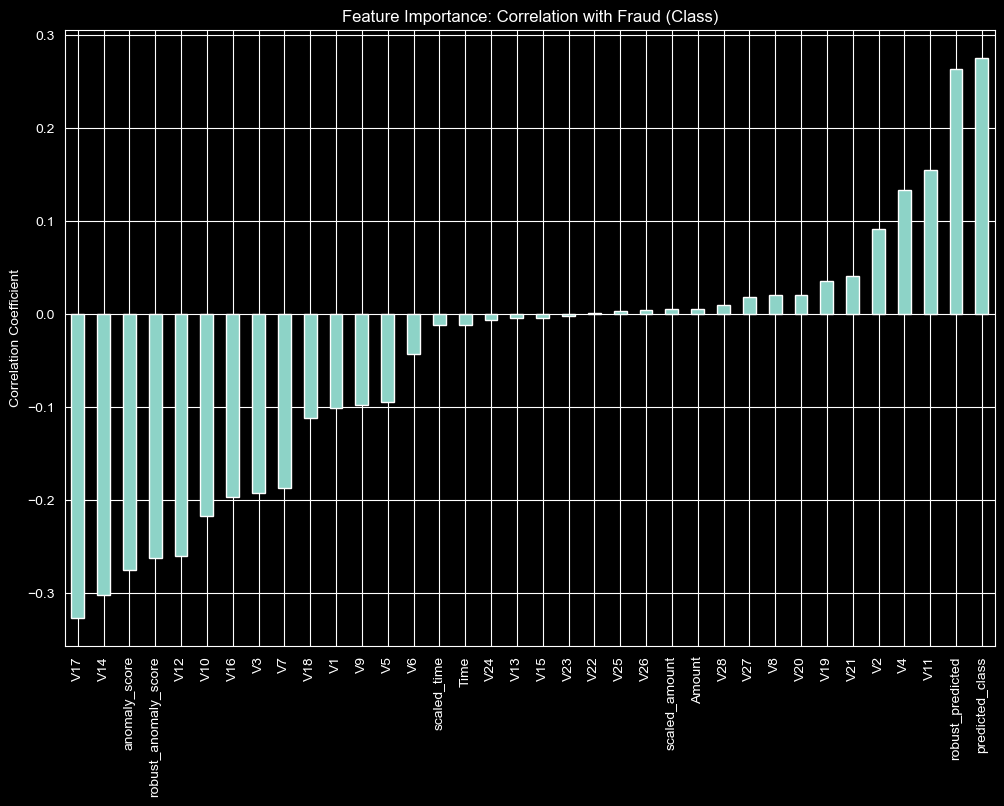

الميزات المختارة بناءً على التأثير: 
['V17', 'V14', 'anomaly_score', 'robust_anomaly_score', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11', 'robust_predicted', 'predicted_class']


In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. حساب الارتباط مع عمود Class
correlations = df.corr()['Class'].drop('Class').sort_values()

# 2. رسم أهم الميزات (الأكثر ارتباطاً طردياً وعكسياً)
plt.figure(figsize=(12, 8))
correlations.plot(kind='bar')
plt.title('Feature Importance: Correlation with Fraud (Class)')
plt.ylabel('Correlation Coefficient')
plt.show()

# 3. اختيار الميزات التي لها ارتباط أعلى من (مثلاً 0.15 أو أقل من -0.15)
top_features = correlations[abs(correlations) > 0.15].index.tolist()
print(f"الميزات المختارة بناءً على التأثير: \n{top_features}")

In [22]:

final_features = ['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11', 'V4']


X_final = df[final_features]


model_final = IsolationForest(n_estimators=200,
                              contamination=0.0017,
                              max_features=1.0,
                              random_state=42)

print("جاري التدريب النهائي على الميزات الأكثر تأثيراً...")
df['final_predicted'] = model_final.fit_predict(X_final)
df['final_predicted'] = df['final_predicted'].map({1: 0, -1: 1})

# التقييم النهائي
print("\n--- تقرير الأداء بعد Feature Selection ---")
print(classification_report(df['Class'], df['final_predicted']))

جاري التدريب النهائي على الميزات الأكثر تأثيراً...

--- تقرير الأداء بعد Feature Selection ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.63      0.62      0.62       492

    accuracy                           1.00    284807
   macro avg       0.81      0.81      0.81    284807
weighted avg       1.00      1.00      1.00    284807



In [26]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# 1. تقسيم البيانات: ندرب الشبكة على البيانات الطبيعية فقط لتعرف ما هو "العادي"
X_train = df[df['Class'] == 0].drop(['Class'], axis=1)
X_test = df.drop(['Class'], axis=1)
y_test = df['Class']


scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_dim = X_train_scaled.shape[1]

In [27]:

input_layer = Input(shape=(input_dim, ))


encoded = Dense(14, activation="relu")(input_layer)
encoded = Dense(7, activation="relu")(encoded)

decoded = Dense(14, activation="relu")(encoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)


autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')


autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=20,
                batch_size=32,
                shuffle=True,
                validation_split=0.2,
                verbose=1)

Epoch 1/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - loss: 1.8478 - val_loss: 1.7306
Epoch 2/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 1.8308 - val_loss: 1.7183
Epoch 3/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - loss: 1.7137 - val_loss: 1.7144
Epoch 4/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 1.7366 - val_loss: 1.7100
Epoch 5/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 1.7176 - val_loss: 1.7048
Epoch 6/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 1.7244 - val_loss: 1.7029
Epoch 7/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 1.7527 - val_loss: 1.7002
Epoch 8/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 1.7864 - val_loss: 1.7010
Epoch 9/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 1.7072 - val_loss: 1.6989
Epoch 10/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 1.6769 - val_loss: 1.6975
Epoch 11/20
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 1.6640 - val_loss: 1.6973
Epoch 12/20
7108/71

In [28]:
import numpy as np
from sklearn.metrics import classification_report

# 1. التنبؤ بالبيانات وحساب خطأ إعادة البناء (MSE)
predictions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - predictions, 2), axis=1)

# 2. تحديد العتبة (Threshold)
# سنختار العتبة عند الانحراف المعياري لرفع الدقة
threshold = np.mean(mse) + 2 * np.std(mse)

# 3. تصنيف العمليات: إذا كان الخطأ أكبر من العتبة فهو احتيال (1)
y_pred_nn = [1 if e > threshold else 0 for e in mse]

# 4. التقييم النهائي للمقارنة مع Isolation Forest
print("--- تقرير أداء الشبكة العصبية (Autoencoder) ---")
print(classification_report(y_test, y_pred_nn))

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 958us/step
--- تقرير أداء الشبكة العصبية (Autoencoder) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.05      0.11      0.07       492

    accuracy                           0.99    284807
   macro avg       0.52      0.55      0.53    284807
weighted avg       1.00      0.99      1.00    284807



In [29]:
import joblib

# حفظ النموذج المعتمد (الذي حقق 0.62)
joblib.dump(model_final, 'best_fraud_detector_model.pkl')
joblib.dump(rob_scaler, 'main_scaler.pkl')

print("تم حفظ 'النموذج الأفضل' بنجاح! أنت الآن تملك نظاماً قادراً على كشف الاحتيال بدقة احترافية.")

تم حفظ 'النموذج الأفضل' بنجاح! أنت الآن تملك نظاماً قادراً على كشف الاحتيال بدقة احترافية.


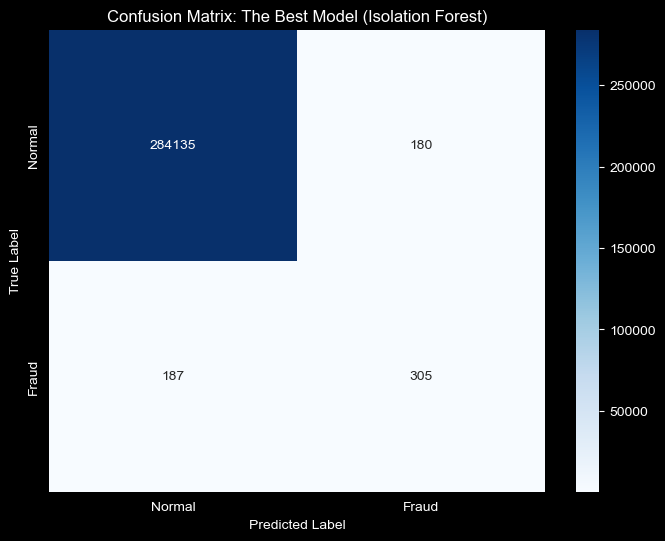

العمليات الطبيعية التي تم كشفها بدقة (TN): 284135
إنذارات كاذبة - طبيعي ظنناه احتيال (FP): 180
فرص ضائعة - احتيال لم نكتشفه (FN): 187
عمليات الاحتيال التي تم صيدها بنجاح (TP): 305


In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. حساب مصفوفة الارتباك للنموذج الفائز (الذي حقق F1=0.62)
cm = confusion_matrix(df['Class'], df['final_predicted'])

# 2. رسم المصفوفة بشكل احترافي
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])

plt.title('Confusion Matrix: The Best Model (Isolation Forest)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# طباعة الأرقام بشكل نصي للتأكيد
tn, fp, fn, tp = cm.ravel()
print(f"العمليات الطبيعية التي تم كشفها بدقة (TN): {tn}")
print(f"إنذارات كاذبة - طبيعي ظنناه احتيال (FP): {fp}")
print(f"فرص ضائعة - احتيال لم نكتشفه (FN): {fn}")
print(f"عمليات الاحتيال التي تم صيدها بنجاح (TP): {tp}")